# Drifter evaluation example

In [2]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from itertools import repeat
from glob import glob
from importlib import reload
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import viz_tools

%matplotlib inline
plt.rcParams['font.size'] = 14

In [61]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix

In [36]:
# Define paths
drifters = loadmat('/ocean/shared/drifters/data/L2/drifters_L2.mat')['drifters'][0]
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'out': '/data/bmoorema/results/opendrift',
    'date_cutoff': '2016 Nov 21',
}
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
daterange1 = [parse(d) for d in ['2016 Jul 19', '2016 Aug 1']]
daterange2 = [parse(d) for d in ['2017 Nov 27', '2017 Dec 15']]

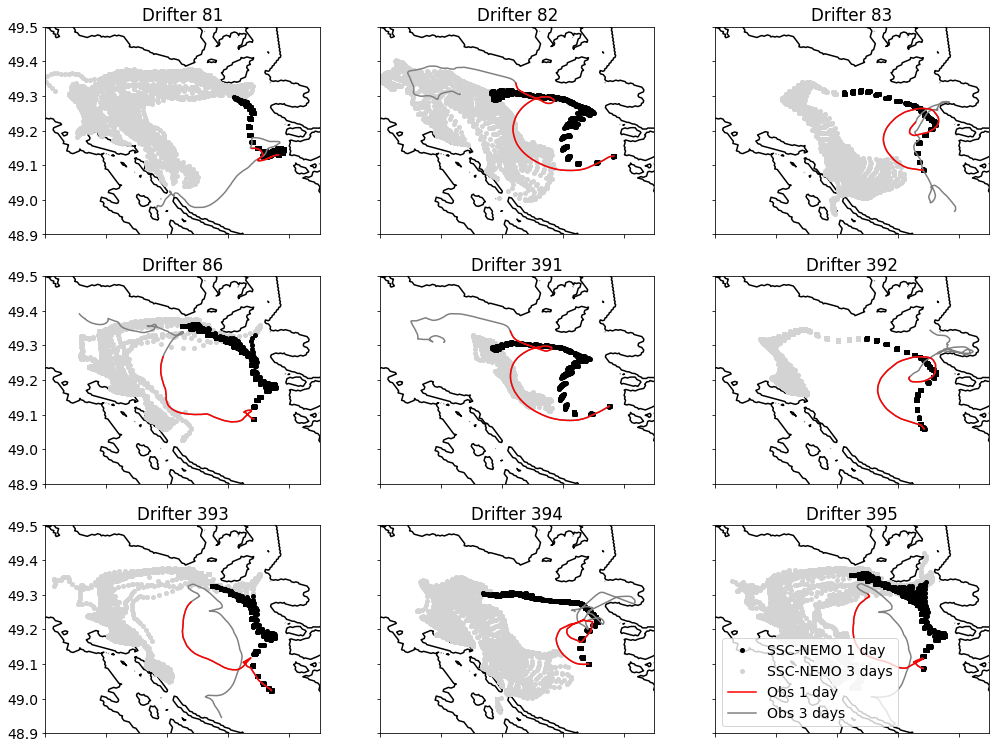

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(17, 13))
axs = axs.reshape(-1)
IDs = [81, 82, 83, 86, 391, 392, 393, 394, 395]
for ax, ID in zip(axs, IDs):
    
    ax.contour(mask.nav_lon, mask.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([-124, -123.1])
    ax.set_ylim([48.9, 49.5])
    viz_tools.set_aspect(ax)
    if ID not in [203, 204, 205]: ax.xaxis.set_ticklabels('')
    if ID not in [81, 86, 393, 200, 203]: ax.yaxis.set_ticklabels('')
    ax.set_title(f'Drifter {ID}')
    
    with xr.open_dataset(os.path.join(paths['out'], 'results', f'drifter_{ID}.nc')) as ds:
        SSC72 = ax.plot(ds.lon[:, :72], ds.lat[:, :72], 'o', color='lightgray', markersize=4)
        SSC24 = ax.plot(ds.lon[:, :24], ds.lat[:, :24], 'ko', markersize=4)
    
    i = 0
    if ID == 391: i = 1
    dindex = np.where(drifters['id'].astype(int) == ID)[0][i]
    t24 = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - 1).argmin()
    t72 = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - 3).argmin()
    OBS72 = ax.plot(drifters['lon'][dindex][:t72], drifters['lat'][dindex][:t72], '-', color='gray')
    OBS24 = ax.plot(drifters['lon'][dindex][:t24], drifters['lat'][dindex][:t24], 'r-')
ax.legend([SSC24[0], SSC72[0], OBS24[0], OBS72[0]], ['SSC-NEMO 1 day', 'SSC-NEMO 3 days', 'Obs 1 day', 'Obs 3 days'])
fig.savefig('/home/bmoorema/Desktop/drifters2016_jul.png', dpi=300, bbox_inches='tight')

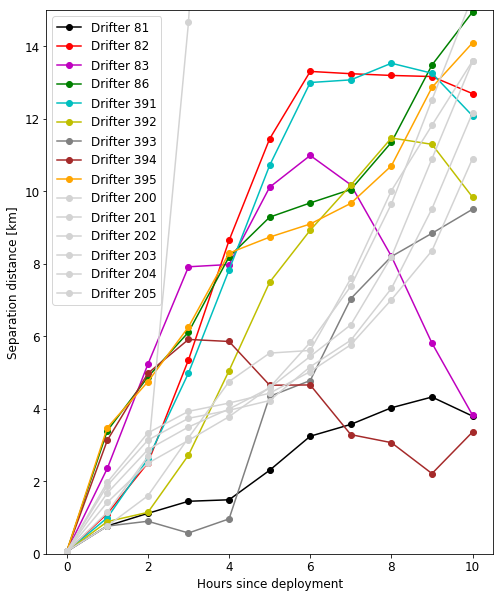

In [53]:
fig, ax = plt.subplots(figsize=(8, 10))

ax.set_xlabel('Hours since deployment')
ax.set_ylabel('Separation distance [km]')
ax.set_ylim([0, 15])

for ID, color in zip(IDs, ['k', 'r', 'm', 'g', 'c', 'y', 'gray', 'brown', 'orange', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray']):
    diffs = []
    i = 0
    if ID == 391: i = 1

    with xr.open_dataset(os.path.join(paths['out'], 'results', f'drifter_{ID}.nc')) as ds:
        for hour in range(11):
            dindex = np.where(drifters['id'].astype(int) == ID)[0][i]
            tindex = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - hour/24).argmin()
            sides2 = []
            for key, corr in zip(['lon', 'lat'], [72, 111]):
                sides2.append(((ds[key][:, hour] - drifters[key][dindex][tindex]) * corr)**2)
            diffs.append(float(np.sqrt(sum(sides2)).mean()))
    ax.plot(range(11), diffs, '-o', color=color, label=f'Drifter {ID}')
ax.legend()
#fig.savefig('/home/bmoorema/Desktop/drifters2016_jul_diff.pdf', bbox_inches='tight')

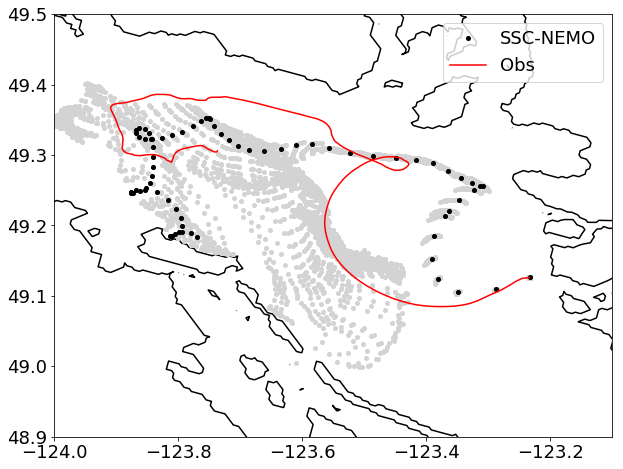

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ID = 82
ax.contour(mask.nav_lon, mask.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124, -123.1])
ax.set_ylim([48.9, 49.5])
viz_tools.set_aspect(ax)
with xr.open_dataset(os.path.join(paths['out'], 'results', f'drifter_{ID}.nc')) as ds:
    ax.plot(ds.lon[:, :72], ds.lat[:, :72], 'o', color='lightgray', markersize=4)
    SSC72 = ax.plot(ds.lon[3, :72], ds.lat[3, :72], 'ko', markersize=4)
dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
t72 = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - 3).argmin()
OBS72 = ax.plot(drifters['lon'][dindex][:t72], drifters['lat'][dindex][:t72], 'r-')
ax.legend([SSC72[0], OBS72[0]], ['SSC-NEMO', 'Obs'])
fig.savefig('/home/bmoorema/Desktop/drifters2016_jul_single.png', dpi=300, bbox_inches='tight')

In [32]:
for drifter in drifters:
    t = drifter['mtime'][0][0]
    print(drifter['id'][0][0], datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days=366))

1 2016-04-18 18:06:29.000002
2 2016-04-18 18:13:06.999996
3 2016-04-18 18:17:22.999995
4 2016-04-18 18:22:05.000005
5 2016-04-18 18:27:00.000004
6 2016-04-18 18:36:00.000002
311 2016-04-18 19:02:59.000001
312 2016-04-18 19:12:10
313 2016-04-18 19:07:59.000004
21 2016-05-02 22:48:30.000004
22 2016-05-04 00:59:07.000002
23 2016-05-10 17:03:22.999999
24 2016-05-10 17:07:05.999996
25 2016-05-16 22:58:35.000002
31 2016-05-12 18:03:33.999996
32 2016-05-12 19:00:23.999997
33 2016-05-12 20:01:05.999997
34 2016-05-12 21:02:02.000002
35 2016-05-12 22:01:04.000002
36 2016-05-12 23:01:29.000003
381 2016-05-10 18:05:28.999996
382 2016-05-10 18:08:46.999998
388 2016-05-10 18:02:00.999997
41 2016-05-26 19:29:35.999999
42 2016-05-26 19:32:56.999995
43 2016-05-26 21:30:35.999999
44 2016-05-26 21:32:34.000003
45 2016-05-26 23:31:34
46 2016-05-26 23:33:28.000005
312 2016-05-24 18:07:06.999997
382 2016-05-24 18:03:27.000004
388 2016-05-24 17:59:39.999998
51 2016-06-06 19:19:29.000003
52 2016-06-06 19:23:2

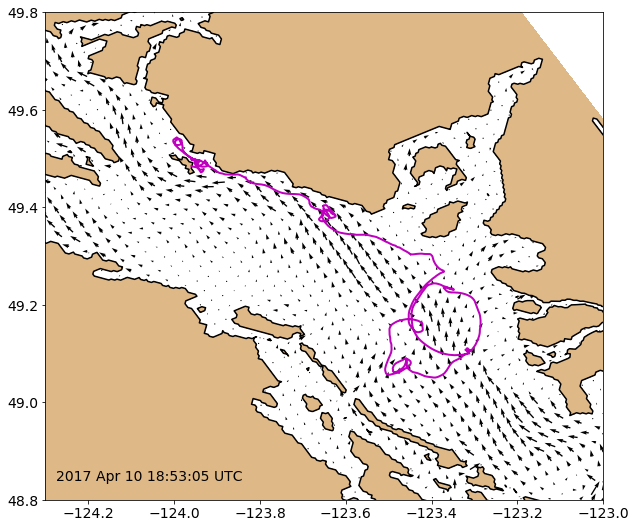

In [93]:
# 133
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-124.3, -123])
ax.set_ylim([48.8, 49.8])
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood', zorder=1)
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k', zorder=1)
viz_tools.set_aspect(ax)

IDs = [133]

for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    ax.plot(drifters['lon'][dindex], drifters['lat'][dindex], 'm-', zorder=1, linewidth=2)

hour = 23
t = drifters['mtime'][dindex][0][0]
date = datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days=366)
u = xr.open_dataset(make_prefix(date, paths) + '_grid_U.nc').vozocrtx[hour, 0, ...].values
v = xr.open_dataset(make_prefix(date, paths) + '_grid_V.nc').vomecrty[hour, 0, ...].values
u, v = viz_tools.rotate_vel(*viz_tools.unstagger(u, v))
ax.quiver(coords.nav_lon[1::5, 1::5], coords.nav_lat[1::5, 1::5], u[::5, ::5], v[::5, ::5], zorder=0)
ax.text(0.02, 0.04, date.strftime('%Y %b %d %H:%M:%S UTC'), transform=ax.transAxes)
fig.savefig('/home/bmoorema/Desktop/drifter_comparison.pdf', bbox_inches='tight')